In [1]:
from data import datasets

quick_draw_dataset = datasets.QuickDrawDataset()
num_images_to_generate = 100000
data_splits = [0.7, 0.2, 0.1]
for i, mode in enumerate(['train', 'val', 'test']):
    datasets.create_composite_dataset((int)(num_images_to_generate * data_splits[i]), mode, quick_draw_dataset)

KeyboardInterrupt: 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import json
from detectron2.data import DatasetCatalog, MetadataCatalog
from data import datasets

dir = 'dataset/composite/'
classes = json.load(open(os.path.join(dir, 'train/labels.json')))

def get_dataset(mode):
    filename = os.path.join(dir, mode + '/data.json')
    with open(filename) as f:
        return json.load(f)

for d in ["train", "val", "test"]:
    DatasetCatalog.register("composite_" + d, lambda d=d: get_dataset(d))
    MetadataCatalog.get("composite_" + d).set(thing_classes=classes)
composite_metadata = MetadataCatalog.get("composite_train")

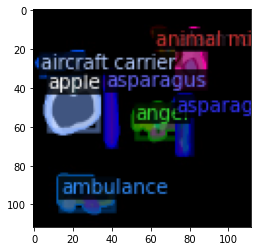

In [2]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

dataset_dicts = DatasetCatalog.get("composite_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=composite_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [4]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
import torch

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("composite_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.MAX_ITER = 20000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.NUM_CLASSES = len(classes)
cfg.INPUT.MASK_FORMAT = "bitmask"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/06 05:31:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [7]:
from detectron2.engine import DefaultPredictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("composite_val", )
predictor = DefaultPredictor(cfg)

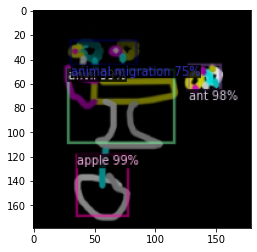

In [8]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dataset("val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=composite_metadata, 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("composite_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "composite_val")
inference_on_dataset(trainer.model, val_loader, evaluator)


WARNING [05/20 04:59:40 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/composite_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[05/20 04:59:42 d2.data.common]: Serializing 20000 elements to byte tensors and concatenating them all ...
[05/20 04:59:42 d2.data.common]: Serialized dataset takes 5.81 MiB
[05/20 04:59:42 d2.evaluation.evaluator]: Start inference on 20000 images
[05/20 04:59:43 d2.evaluation.evaluator]: Inference done 11/20000. 0.0795 s / img. ETA=0:26:52
[05/20 04:59:48 d2.evaluation.evaluator]: Inference done 73/20000. 0.0798 s / img. ETA=0:27:00
[05/20 04:59:54 d2.evaluation.evaluator]: Inference done 134/20000. 0.0805 s / img. ETA=0:27:10
[05/20 04:59:59 d2.evaluation.evaluator]: Inference done 195/20000. 0.0809 s / img. ETA=0:27:12
[05/20 05:00:04 d2.evaluation.evaluator]: Inference done 255/20000. 0.0812 s / img. ETA=0:27:14
[05/20 05:00:09 d2.evaluation.evaluator]: Inference done 314/200

OrderedDict([('bbox',
              {'AP': 75.13999175996577,
               'AP50': 89.77399527588706,
               'AP75': 85.008569708346,
               'APs': 69.76344848391994,
               'APm': 76.97039726438136,
               'APl': 66.2864824901105,
               'AP-apple': 87.11327654311364,
               'AP-ambulance': 84.2716693737699,
               'AP-angel': 82.54459074331909,
               'AP-arm': 75.94910861521333,
               'AP-alarm clock': 80.46086307381492,
               'AP-airplane': 78.28838692490548,
               'AP-aircraft carrier': 58.56366964617868,
               'AP-asparagus': 64.18783242767361,
               'AP-ant': 74.26751778190567,
               'AP-axe': 77.93853328030424,
               'AP-anvil': 80.91415955446787,
               'AP-animal migration': 57.180293154922914})])